In [1]:
import numpy as np
from decimal import Decimal
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.signal import find_peaks, peak_prominences, peak_widths
import time
import multiprocessing as mp
import pandas as pd
import copy
import sys
import matplotlib.gridspec as gridspec
from matplotlib.colors import Normalize, BoundaryNorm, LogNorm
from matplotlib.ticker import MaxNLocator
from scipy.special import powm1

solver=["BDF","RK23","LSODA","Radau"]
omega=13
k0 = [1.19*omega, 1.2, 90, 1.6*omega, 0.03, 0.226, 2.4, 2, 0.472/omega, 0.3, 0.001, 50, 
      0.001, 20, 7.3, 320, 5.4, 0.15, 2, 0.05, 800*omega, 0.68, 0.3]
n0 = [2,3,3,4]
L0 = 0.3
Km0 = [0.03/omega, 0.3*omega, 0.05*omega, 5*omega, 2*omega, 0.18*omega, 0.02*omega]

param0=np.zeros(35)
param0[0:23]=k0
param0[23:27]=n0
param0[27:34]=Km0
param0[34]=L0

In [2]:
files="data_pa_LD0_Km[0]=0.csv"
sim="Km_0=0"
df = pd.read_csv(files)
p=df["0"]
a=df["1"]
files="data_param_LD0_Km[0]=0.csv"
param = pd.read_csv(files)
param.pop("Unnamed: 0")
param.columns=pd.Index(['k_0','k_1','k_2','k_3','k_4','k_5','k_6','k_7','k_8','k_9','k_10','k_11','k_12','k_13','k_14','k_15','k_16','k_17','k_18','k_19','k_20','k_21','k_22','n_0','n_1','n_2','n_3','Km_0','Km_1','Km_2','Km_3','Km_4','Km_5','Km_6','L'])


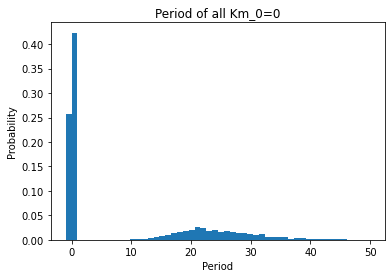

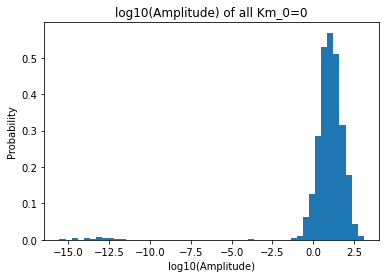

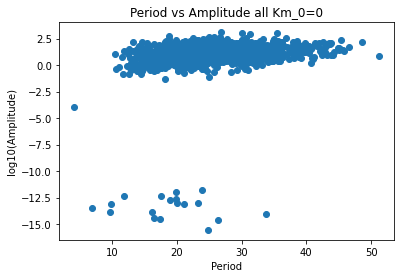

In [3]:
plt.hist(p,bins=52,range=(-1,50),density=True)
plt.title("Period of all "+sim)
plt.xlabel("Period")
plt.ylabel("Probability")
plt.savefig("Period_all_{}.jpg".format(sim))
plt.show()
plt.hist(np.log10(a[a>0]),bins=50,density=True)
plt.title("log10(Amplitude) of all "+sim)
plt.xlabel("log10(Amplitude)")
plt.ylabel("Probability")
plt.savefig("Amplitude_all{}.jpg".format(sim))
plt.show()
plt.scatter(p[a>0],np.log10(a[a>0]))
plt.title("Period vs Amplitude all "+sim)
plt.xlabel("Period")
plt.ylabel("log10(Amplitude)")
plt.savefig("PeriodvsAmplitude_all_{}.jpg".format(sim))
plt.show()

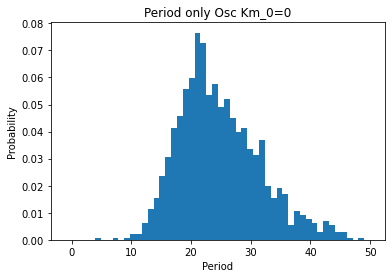

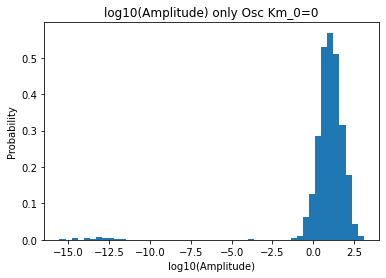

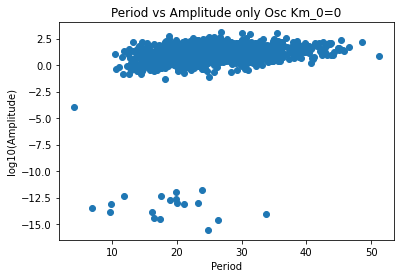

In [4]:
index=list(p>0)

plt.hist(p[index],bins=52,range=(-1,50),density=True)
plt.title("Period only Osc "+sim)
plt.xlabel("Period")
plt.ylabel("Probability")
plt.savefig("Period_Osc_{}.jpg".format(sim))
plt.show()
plt.hist(np.log10(a[index][a[index]>0]),bins=50,density=True)
plt.title("log10(Amplitude) only Osc "+sim)
plt.xlabel("log10(Amplitude)")
plt.ylabel("Probability")
plt.savefig("Amplitude_Osc_{}.jpg".format(sim))
plt.show()
plt.scatter(p[index][a[index]>0],np.log10(a[index][a[index]>0]))
plt.title("Period vs Amplitude only Osc "+sim)
plt.xlabel("Period")
plt.ylabel("log10(Amplitude)")
plt.savefig("PeriodvsAmplitude_Osc_{}.jpg".format(sim))
plt.show()

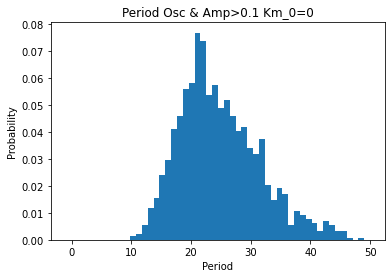

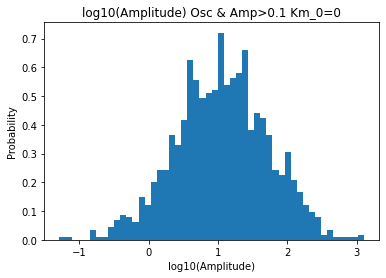

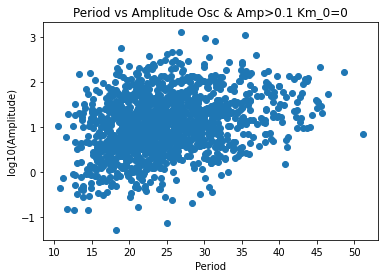

In [5]:
index=list(p>0) and list(a>=.01)

plt.hist(p[index],bins=52,range=(-1,50),density=True)
plt.title("Period Osc & Amp>0.1 "+sim)
plt.xlabel("Period")
plt.ylabel("Probability")
plt.savefig("Period_OscAmp_{}.jpg".format(sim))
plt.show()
plt.hist(np.log10(a[index]),bins=50,density=True)
plt.title("log10(Amplitude) Osc & Amp>0.1 "+sim)
plt.xlabel("log10(Amplitude)")
plt.ylabel("Probability")
plt.savefig("Amplitude_OscAmp_{}.jpg".format(sim))
plt.show()
plt.scatter(p[index],np.log10(a[index]))
plt.title("Period vs Amplitude Osc & Amp>0.1 "+sim)
plt.xlabel("Period")
plt.ylabel("log10(Amplitude)")
plt.savefig("PeriodvsAmplitude_OscAmp_{}.jpg".format(sim))
plt.show()

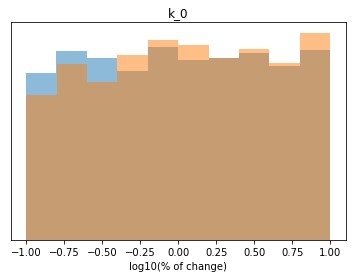

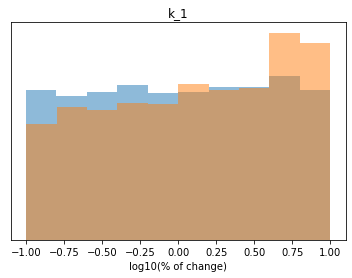

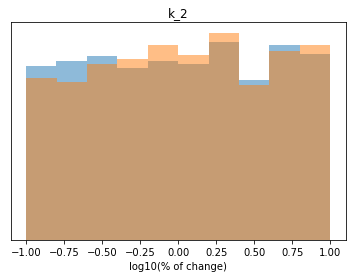

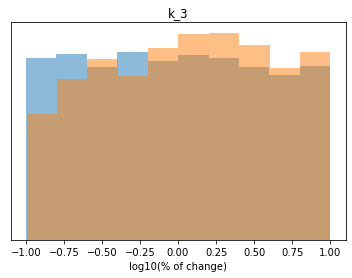

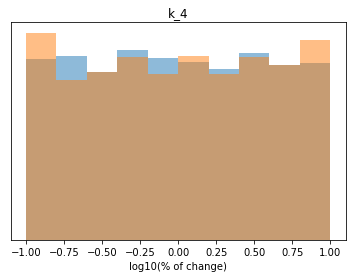

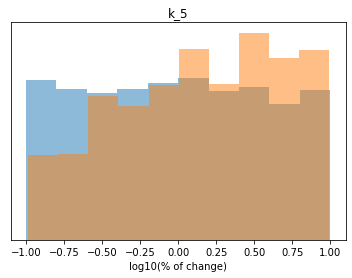

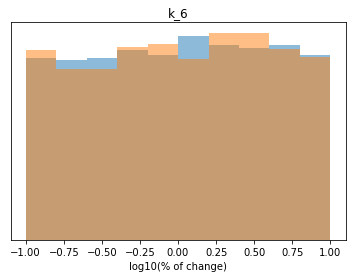

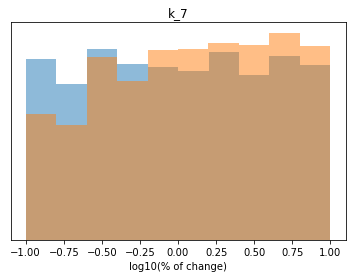

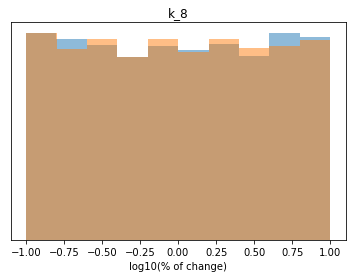

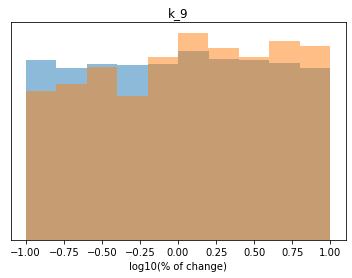

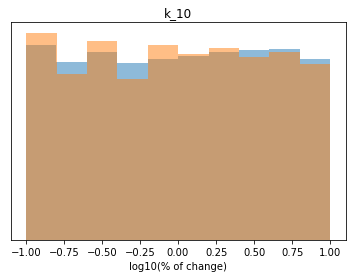

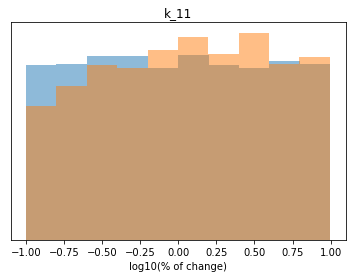

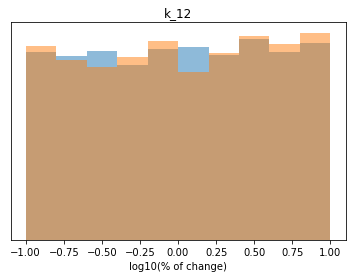

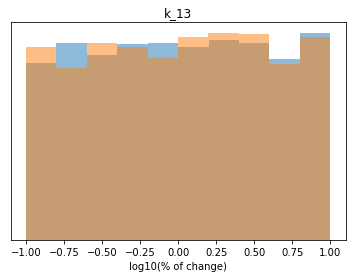

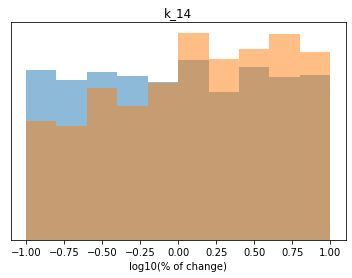

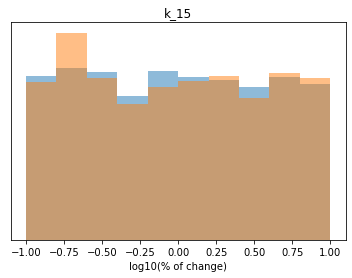

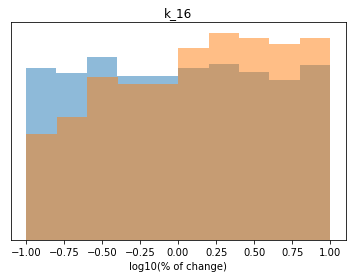

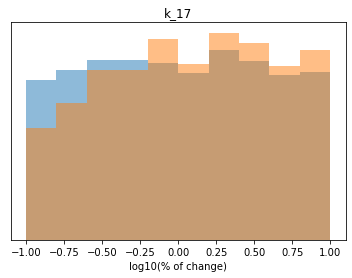

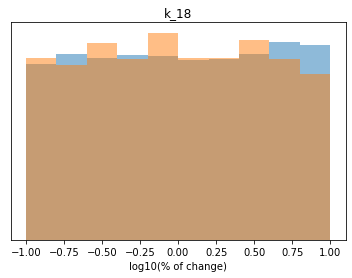

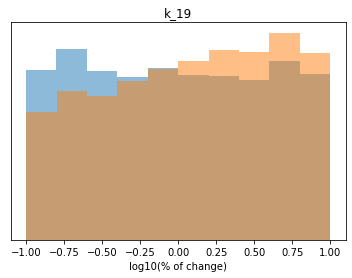

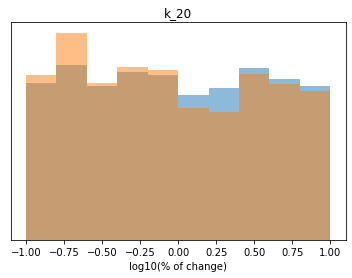

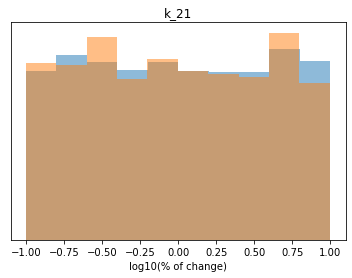

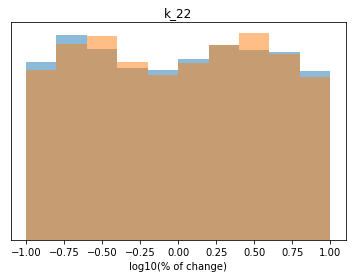

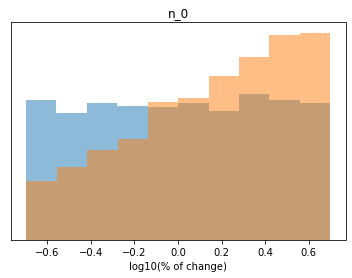

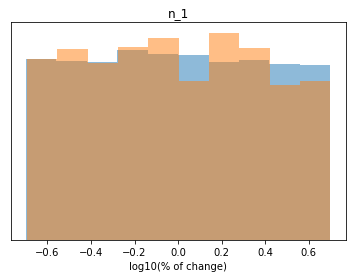

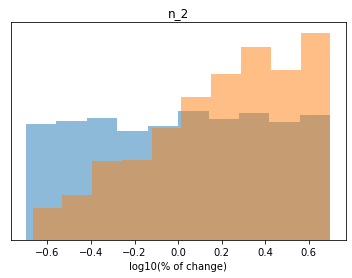

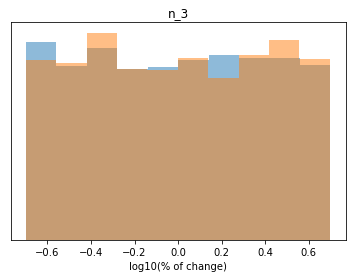

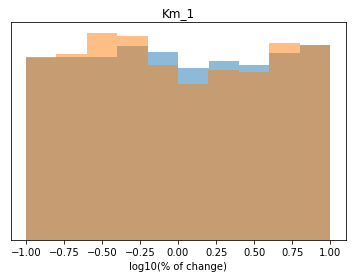

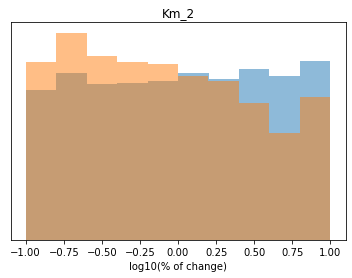

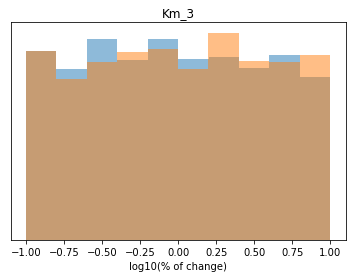

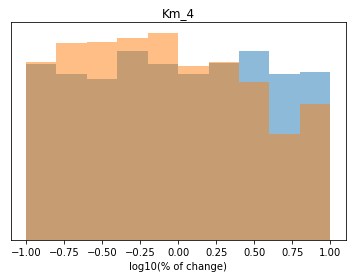

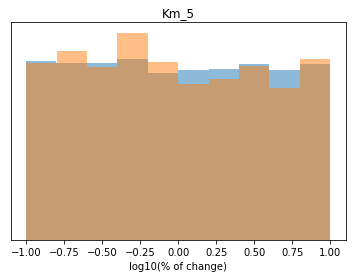

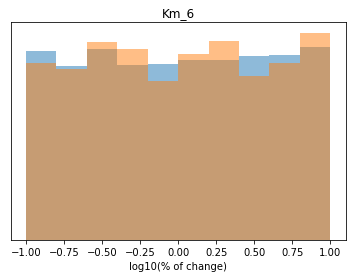

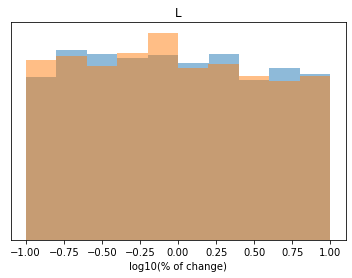

In [6]:
par_n=param/param0
h=np.zeros((35,10))
h1=np.zeros((35,10))
for j,i in enumerate(par_n.columns):
    if i in sim:
        continue
    h[j]=plt.hist(np.log10(par_n[i]),density=True,alpha=0.5)[0]
    h1[j]=plt.hist(np.log10(par_n[i][index]),density=True,alpha=0.5)[0]
    plt.title(i)
    plt.xlabel("log10(% of change)")
    plt.yticks([])
    plt.savefig("{}_hist_{}.jpg".format(i,sim))
    plt.show()

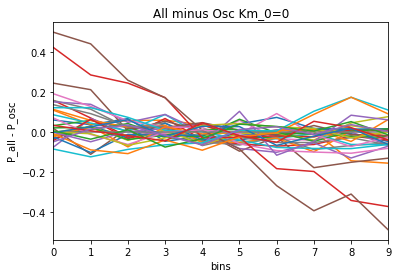

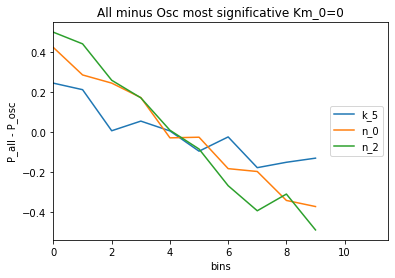

In [7]:
def significative(it):
    sm=sum(abs(it[abs(it)>=0.2]))
    return sm
dif=(h-h1)
ind=np.array([significative(i) for i in dif])>0
plt.plot(dif.T)
plt.xlim(0,9)
plt.title("All minus Osc "+sim)
plt.xlabel("bins")
plt.ylabel("P_all - P_osc")
plt.show()
plt.plot(dif[ind].T)
plt.title("All minus Osc most significative "+sim)
plt.xlabel("bins")
plt.ylabel("P_all - P_osc")
plt.legend(par_n.columns[ind],loc="right")
plt.xlim(0,11.5)
plt.show()

In [8]:
len(dif[ind])

3

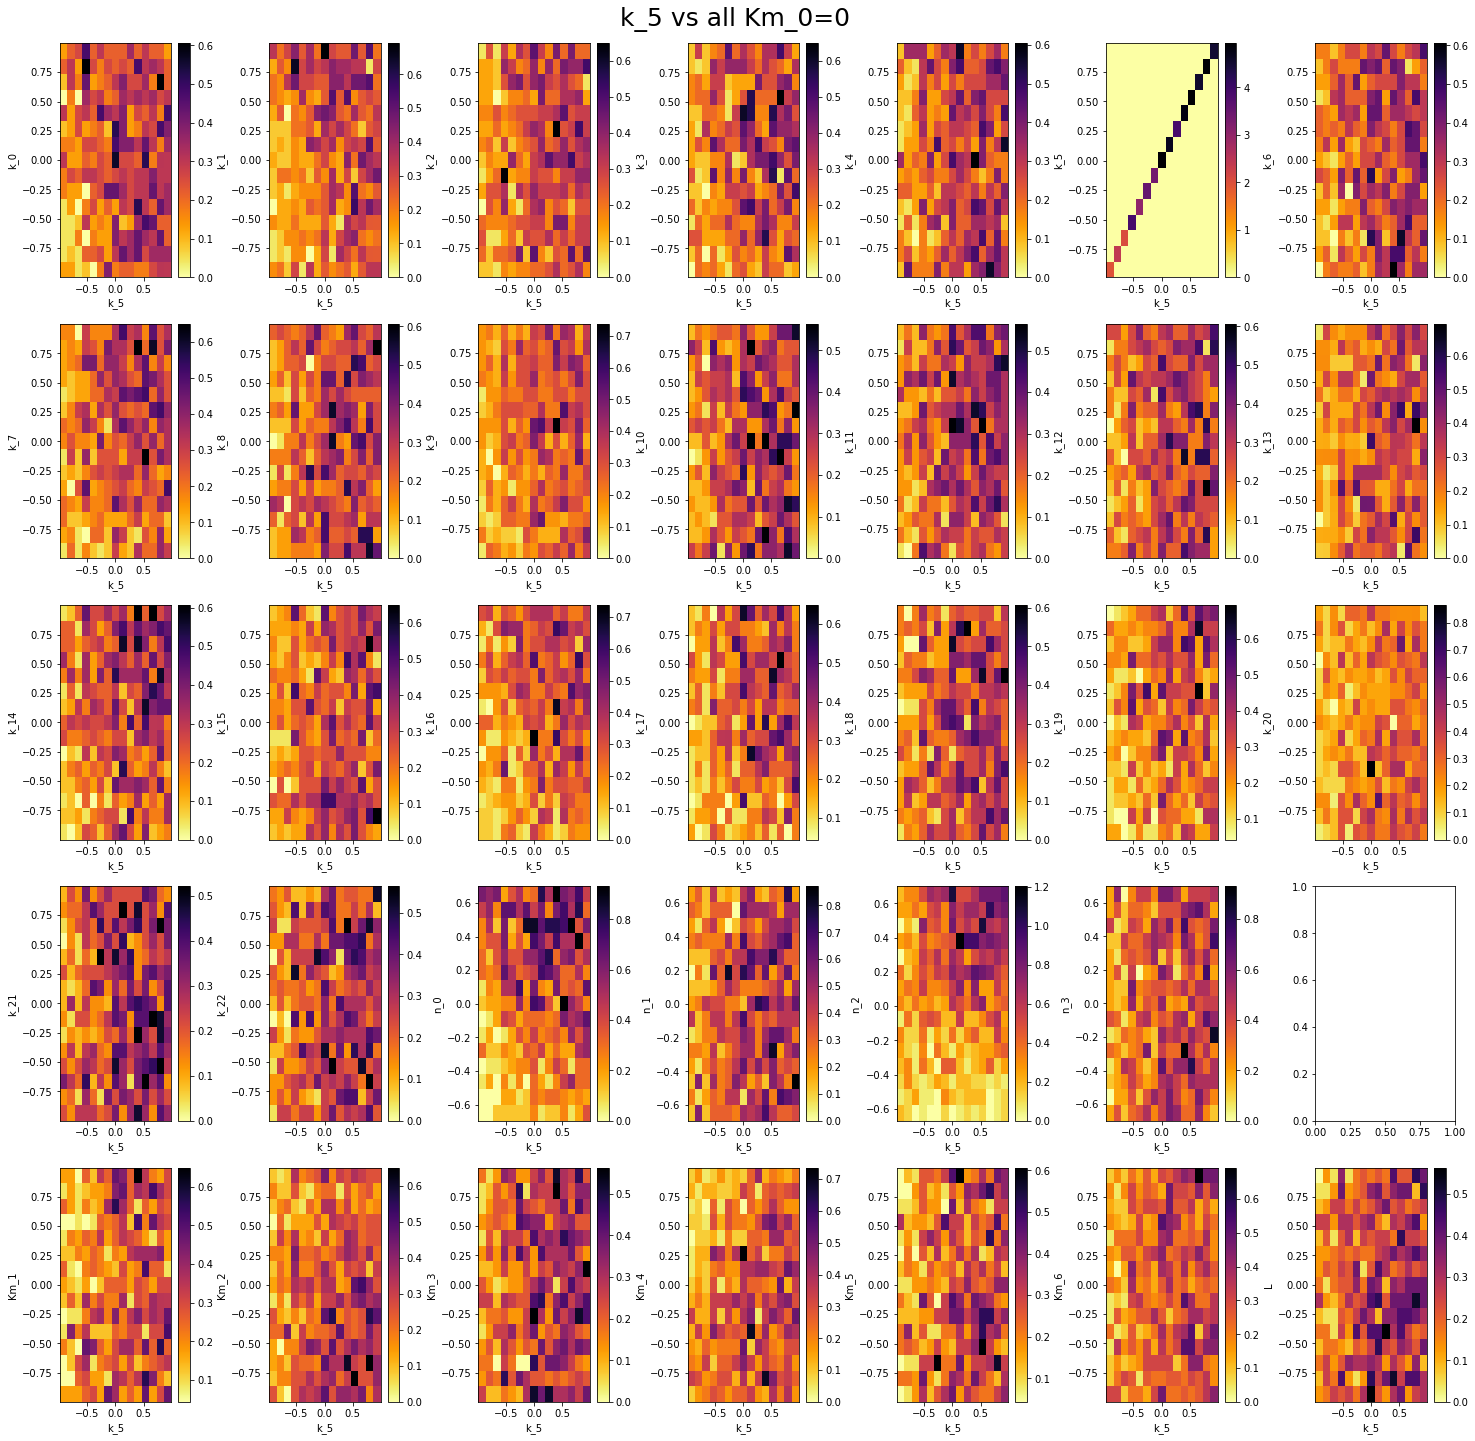

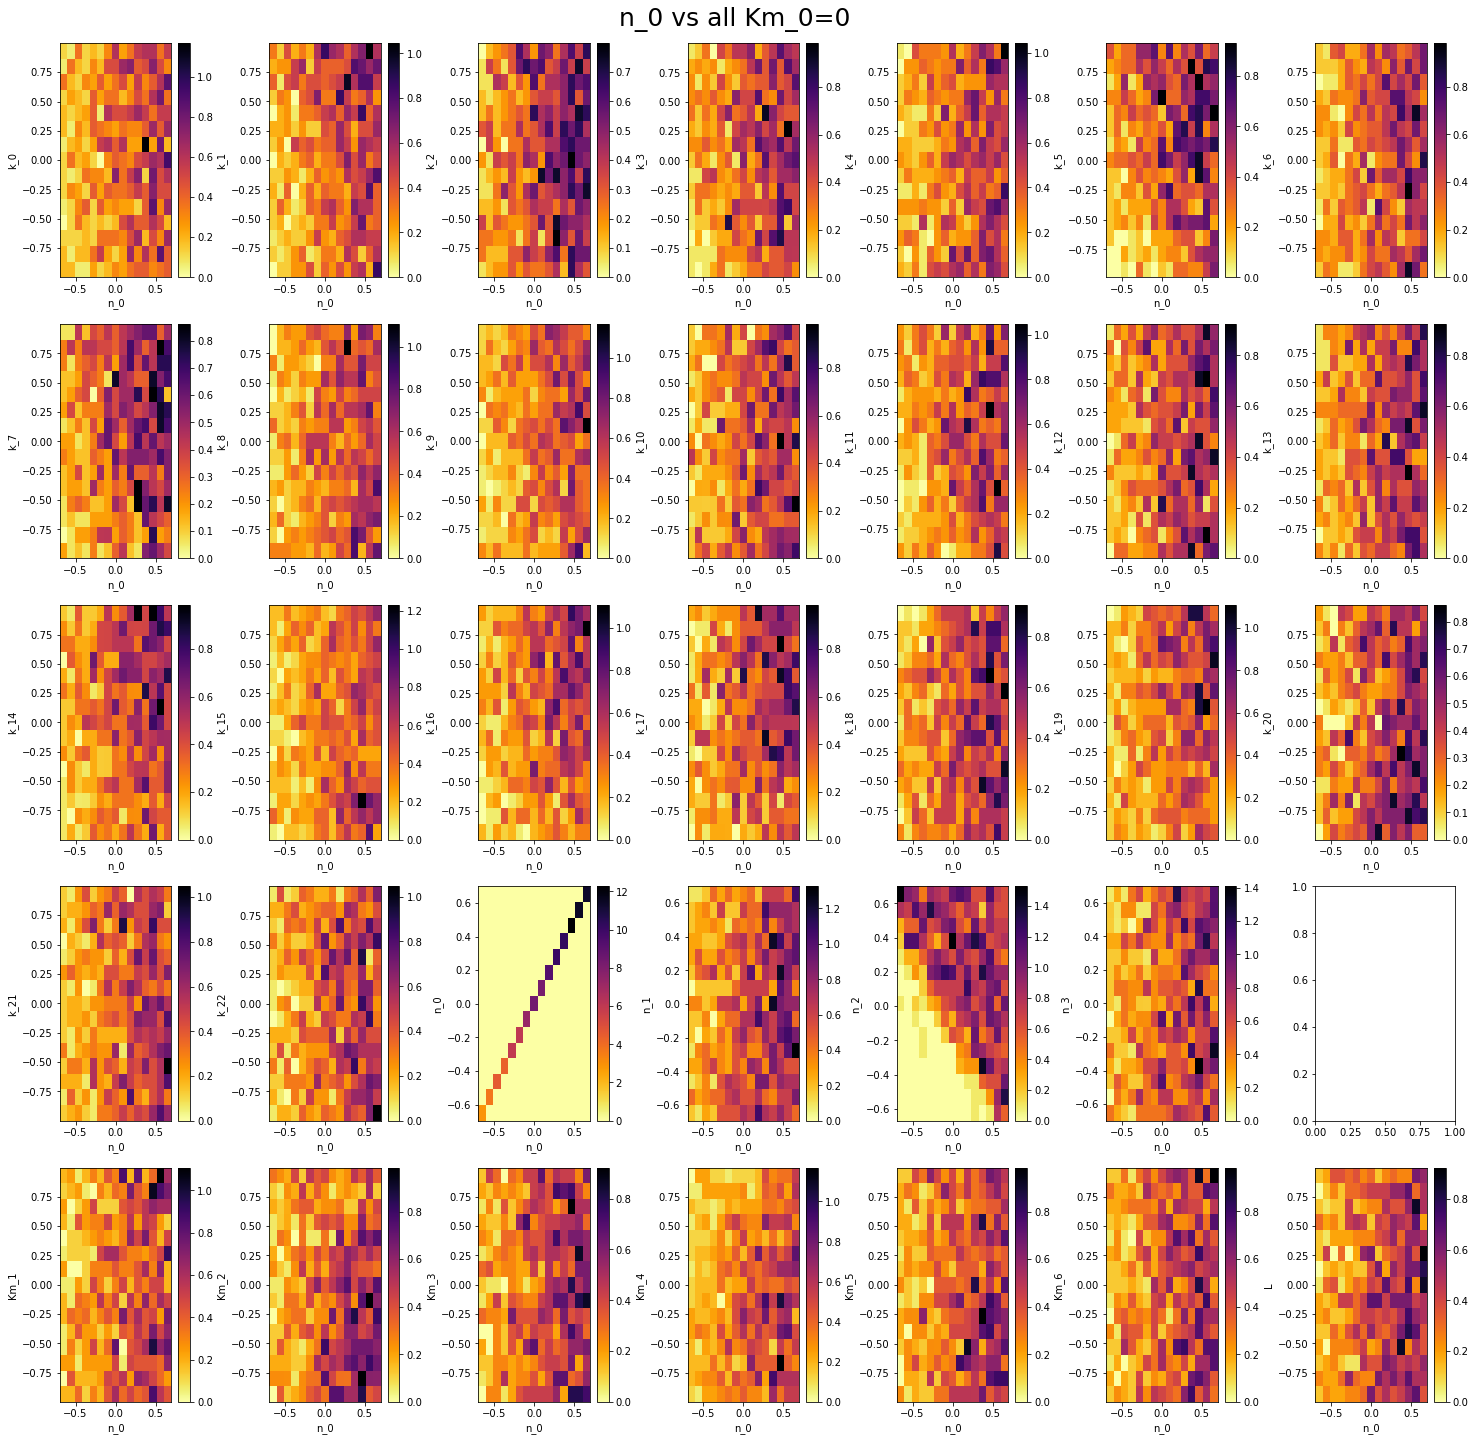

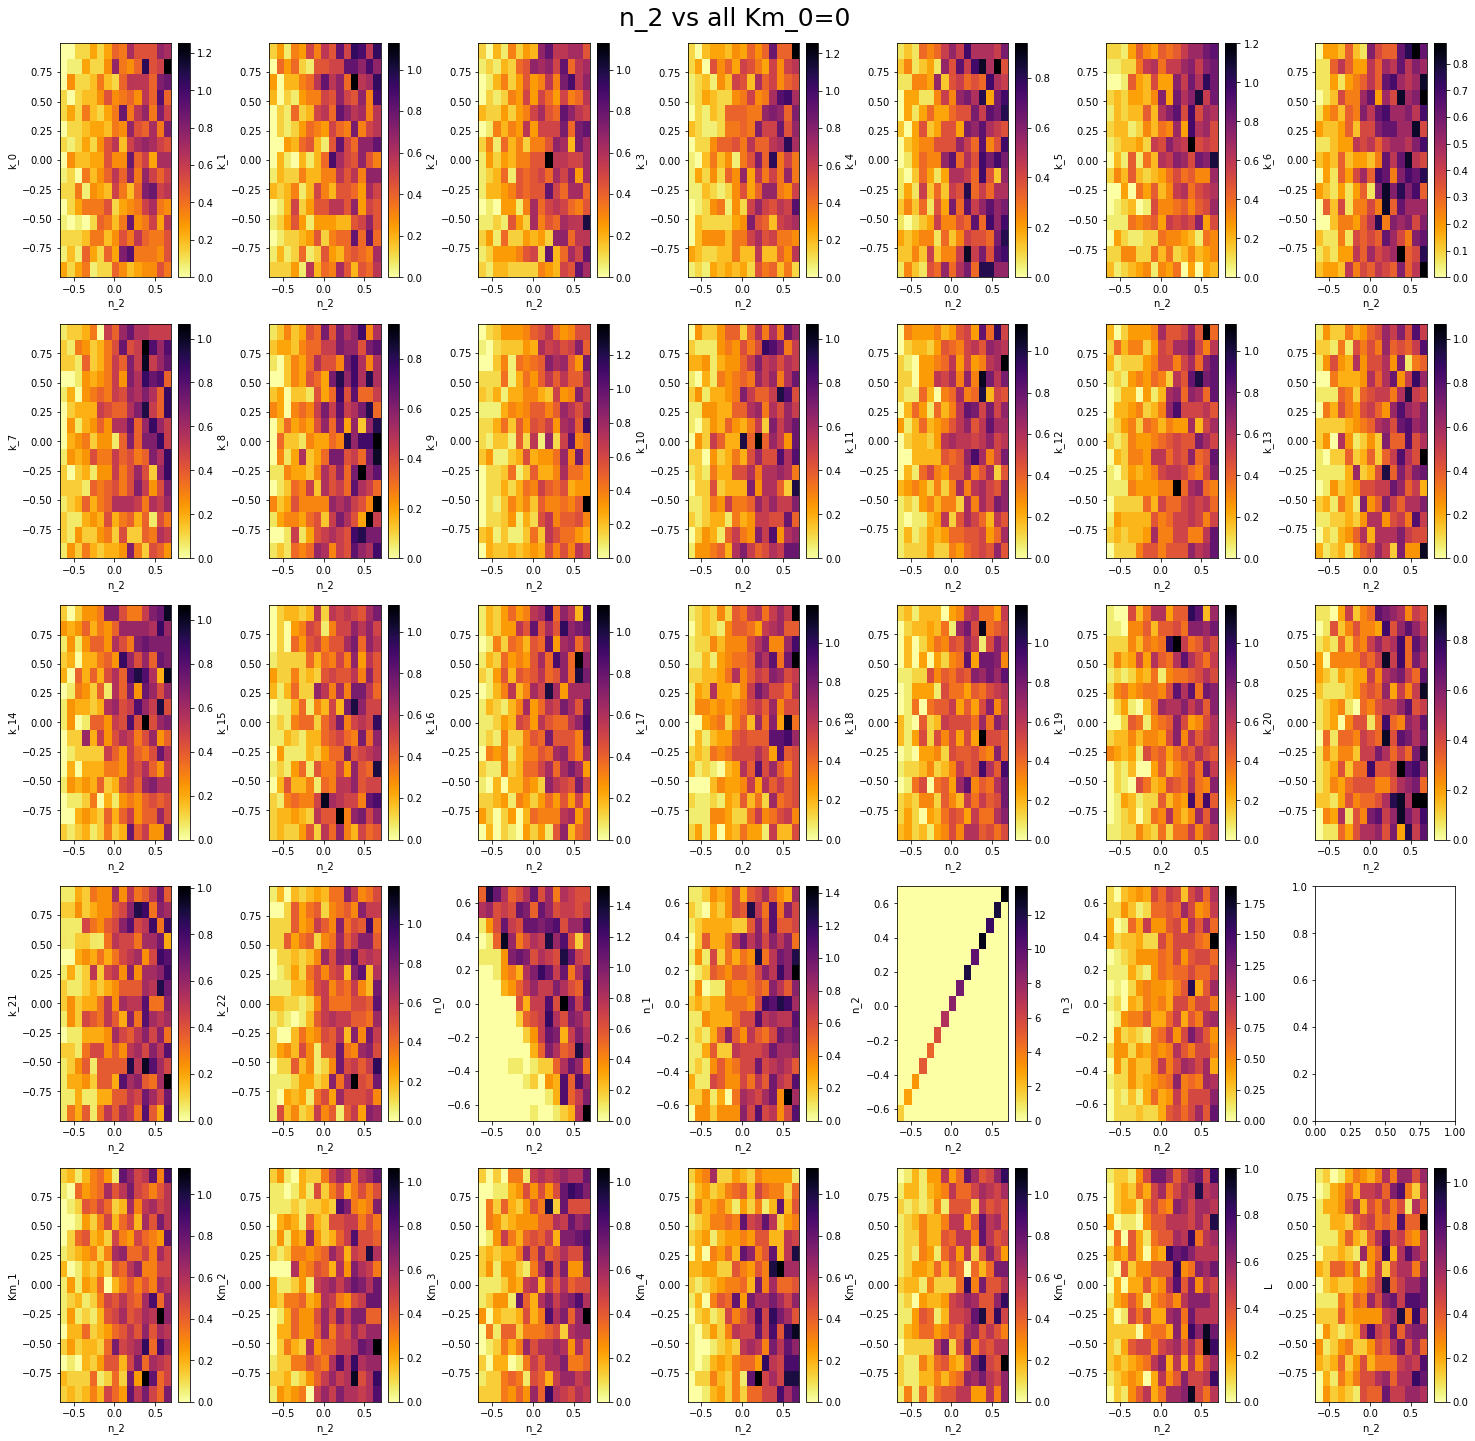

In [9]:
cmap=plt.colormaps['inferno_r']
for k in par_n.columns[ind]:
    fig,ax=plt.subplots(5,7,figsize=(25,25))
    for j,i in enumerate(par_n.columns):
        if i in sim:
            continue
        hist=ax[j//7,j%7].hist2d(np.log10(par_n[k][index]),np.log10(par_n[i][index]),density=True,bins=15,cmap=cmap)
        ax[j//7,j%7].set_xlabel(k)
        ax[j//7,j%7].set_ylabel(i)
        fig.colorbar(hist[3],ax=ax[j//7,j%7])
    plt.suptitle(k+" vs all "+sim,y=.9,fontsize=25)
    plt.subplots_adjust(wspace=.5)
    plt.savefig("{}vsAll_{}.jpg".format(k,sim))
    plt.show()